# Plot distance of different layers

In [6]:
import sys
import torch.nn as nn
import torchvision
import copy

from torchvision import transforms

from resnet_multi_bn_default_pgd import multi_bn_resnet18


import torch

# def get_no_current_minibatch_stat_bn(channel):
#     return nn.BatchNorm2d(channel, momentum=1)

# norm_layer = get_no_current_minibatch_stat_bn

# model_for_test = multi_bn_resnet18(norm_layer=norm_layer, bn_names=["pgd", "normal"]).cuda()
# model_path_epoch110='../log_files/BAT-Imagenette-Hybrid_dual_bn/BAT-Imagenette-Hybrid_dual_bn-Madry_mixture_bn--epochs_110-weight_decay_0.0005-lr_max_0.1-epsilon_0.06274509803921569-num_steps_10-step_size_0.00784313725490196-seed_0-/20220410144724_1wuycuyq/modle-epoch110.pt'

# model_state_dict = torch.load(model_path_epoch110)
# model_for_test.load_state_dict(model_state_dict)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
trainset = torchvision.datasets.CIFAR10(root='/dev/shm', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True,)
testset = torchvision.datasets.CIFAR10(root='/dev/shm', train=False, download=True, transform=transform_test)
testset.data = testset.data[:1000]
testset.targets = testset.targets[:1000]

test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, )

epsilon_interge = 16
epsilon = epsilon_interge/255.
noise_size = 1.0


def generate_noise(x_natural,
                noise_size= 0.0,
                epsilon=0.031,
                ):
    current_noise_size = epsilon * noise_size
    input_noise = torch.zeros_like(x_natural).cuda()
    input_noise.uniform_(-current_noise_size, current_noise_size)
    noise_images = x_natural + input_noise
    return noise_images

def generate_adv(model,
                x_natural,
                y,
                optimizer=None,
                step_size=0.003,
                epsilon=0.031,
                perturb_steps=10,
                bn_name="pgd",
                ):

    model.eval()

    loss = nn.CrossEntropyLoss()
    adv_images = x_natural.clone().detach()

    adv_images = adv_images + torch.empty_like(adv_images).uniform_(-epsilon, epsilon)
    adv_images = torch.clamp(adv_images, min=0, max=1).detach()

    for _ in range(perturb_steps):
        adv_images.requires_grad = True

        if bn_name:
            outputs = model(adv_images, bn_name)
        else:
            outputs = model(adv_images)

        # Calculate loss
        cost = loss(outputs, y)

        grad = torch.autograd.grad(cost, adv_images,
                                    retain_graph=False, create_graph=False)[0]

        adv_images = adv_images.detach() + step_size*grad.sign()
        delta = torch.clamp(adv_images - x_natural, min=-epsilon, max=epsilon)
        adv_images = torch.clamp(x_natural + delta, min=0, max=1).detach()

    return adv_images


# measure the mismatch between clean and adv
def get_no_current_minibatch_stat_bn(channel):
    return nn.BatchNorm2d(channel, momentum=1)
norm_layer = get_no_current_minibatch_stat_bn
bn_names = ["pgd", "normal"]

model_for_measure = multi_bn_resnet18(norm_layer=norm_layer, bn_names=bn_names).cuda()
# model_for_measure = multi_bn_resnet18(norm_layer=norm_layer, bn_names=bn_names, num_classes=10).cuda()
model_for_measure_noise = multi_bn_resnet18(norm_layer=norm_layer, bn_names=bn_names).cuda()
# model_for_measure_noise = multi_bn_resnet18(norm_layer=norm_layer, bn_names=bn_names, num_classes=10).cuda()
model_for_measure.conv1 = nn.Conv2d(
    3, 64, kernel_size=3, stride=1, padding=2, bias=False
)
model_for_measure.maxpool = nn.Identity()

model_for_measure_noise.conv1 = nn.Conv2d(
    3, 64, kernel_size=3, stride=1, padding=2, bias=False
)
model_for_measure_noise.maxpool = nn.Identity()


model_path_epoch110='../../OCT/code/log_files/pgd_default-baselineexperiment-Clean_loss/pgd_default-baselineexperiment-Clean_loss-Clean_loss--epochs_110-weight_decay_0.0005-lr_max_0.1-epsilon_0.03137254901960784-num_steps_10-step_size_0.00784313725490196-seed_0-/20220927142405_26u2t7xx/modle-epoch110.pt'

model_state_dict = torch.load(model_path_epoch110)
clean_stat = copy.deepcopy(model_state_dict)

model_for_measure.load_state_dict(model_state_dict)
model_for_measure_noise.load_state_dict(model_state_dict)
# get the stat for clean image
print("extra feature")
model_for_measure.train()
model_for_measure_noise.train()
for batch_id, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()
    model_for_measure, model_for_measure_noise = model_for_measure.cuda(), model_for_measure_noise.cuda()
    
    data_adv = generate_adv(model_for_measure, data, target, None, step_size=epsilon/4, epsilon=epsilon, perturb_steps=10)
    data_noise = generate_noise(data, noise_size, epsilon)

    model_for_measure.train()
    model_for_measure(data_adv)
    adv_stat = copy.deepcopy(model_for_measure.state_dict())
    # model_for_measure(data)
    # clean_stat = copy.deepcopy(model_for_measure.state_dict())

    
    model_for_measure_noise.train()
    model_for_measure_noise(data_noise)
    noise_stat = copy.deepcopy(model_for_measure_noise.state_dict())
    # model_for_measure_noise(data)
    # clean_stat = copy.deepcopy(model_for_measure_noise.state_dict())
    break

from scipy.stats import wasserstein_distance as wass_dis

dis_measure_saver_mean = {}
dis_measure_saver_var = {}

for (adv_bn_stat_key, adv_bn_stat_value), (clean_bn_stat_key, clean_bn_stat_value) in zip(adv_stat.items(), clean_stat.items()):
    if "bn_list.0.running_mean" in adv_bn_stat_key:
        # import ipdb;ipdb.set_trace()
        adv_clean_wass_dis = wass_dis(adv_bn_stat_value.cpu().numpy(), clean_bn_stat_value.cpu().numpy())

        dis_measure_saver_mean[adv_bn_stat_key] = adv_clean_wass_dis
    if "bn_list.0.running_var" in adv_bn_stat_key:
        # adv_clean_wass_dis = wass_dis(adv_bn_stat_value.cpu().numpy(), clean_bn_stat_value.cpu().numpy())
        adv_clean_wass_dis = wass_dis(torch.sqrt(adv_bn_stat_value).cpu().numpy(), torch.sqrt(clean_bn_stat_value).cpu().numpy())
        dis_measure_saver_var[adv_bn_stat_key] = adv_clean_wass_dis


dis_measure_saver_mean_noise = {}
dis_measure_saver_var_noise = {}

for (noise_bn_stat_key, noise_bn_stat_value), (clean_bn_stat_key, clean_bn_stat_value) in zip(noise_stat.items(), clean_stat.items()):
    if "bn_list.0.running_mean" in noise_bn_stat_key:
        # import ipdb;ipdb.set_trace()
        noise_clean_wass_dis = wass_dis(noise_bn_stat_value.cpu().numpy(), clean_bn_stat_value.cpu().numpy())

        dis_measure_saver_mean_noise[noise_bn_stat_key] = noise_clean_wass_dis
    if "bn_list.0.running_var" in noise_bn_stat_key:
        # adv_clean_wass_dis = wass_dis(adv_bn_stat_value.cpu().numpy(), clean_bn_stat_value.cpu().numpy())
        noise_clean_wass_dis = wass_dis(torch.sqrt(noise_bn_stat_value).cpu().numpy(), torch.sqrt(clean_bn_stat_value).cpu().numpy())
        dis_measure_saver_var_noise[noise_bn_stat_key] = noise_clean_wass_dis



Files already downloaded and verified
Files already downloaded and verified
extra feature


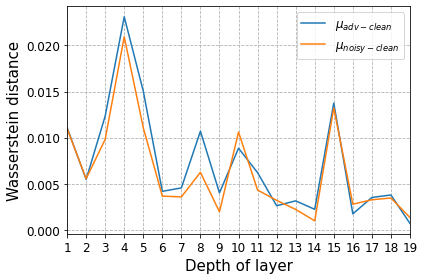

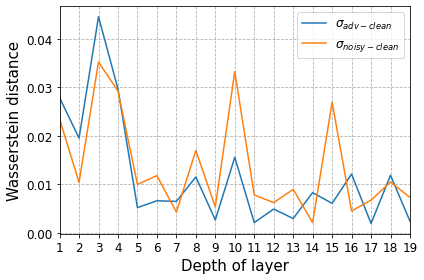

In [7]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot([v for k, v in dis_measure_saver_mean.items()], label="$\mu_{adv-clean}$")
plt.plot([v for k, v in dis_measure_saver_mean_noise.items()], label="$\mu_{noisy-clean}$")
plt.legend(fontsize=12)

plt.ylabel("Wasserstein distance", fontsize=15)
plt.xlabel("Depth of layer", fontsize=15)
# plt.xticks(fontsize=12)
plt.xticks([i for i in range(1, 21)], fontsize=12)
plt.yticks( fontsize=12)

plt.xlim([1,19])
plt.grid(linestyle='--')
plt.tight_layout()
plt.savefig(f"depth_of_layer_cosine_similarity_mean_adv_sample_noise_sample_eps{epsilon_interge}.png")
plt.show()


plt.figure()
plt.plot([v for k, v in dis_measure_saver_var.items()], label="$\sigma_{adv-clean}$")
plt.plot([v for k, v in dis_measure_saver_var_noise.items()], label="$\sigma_{noisy-clean}$")
plt.legend(fontsize=12)

plt.ylabel("Wasserstein distance", fontsize=15)
plt.xlabel("Depth of layer", fontsize=15)
plt.xticks([i for i in range(1, 21)], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks( fontsize=12)

plt.xlim([1,19])
plt.grid(linestyle='--')
plt.tight_layout()
plt.savefig(f"depth_of_layer_cosine_similarity_std_adv_sample_noise_sample_eps{epsilon_interge}.png")

plt.show()


# Evaluate standard training model with noised inputs 


In [20]:
import sys
import torch.nn as nn
import torchvision
import copy

from torchvision import transforms

from resnet_multi_bn_default_pgd import multi_bn_resnet18


import torch

# def get_no_current_minibatch_stat_bn(channel):
#     return nn.BatchNorm2d(channel, momentum=1)

# norm_layer = get_no_current_minibatch_stat_bn

# model_for_test = multi_bn_resnet18(norm_layer=norm_layer, bn_names=["pgd", "normal"]).cuda()
# model_path_epoch110='../log_files/BAT-Imagenette-Hybrid_dual_bn/BAT-Imagenette-Hybrid_dual_bn-Madry_mixture_bn--epochs_110-weight_decay_0.0005-lr_max_0.1-epsilon_0.06274509803921569-num_steps_10-step_size_0.00784313725490196-seed_0-/20220410144724_1wuycuyq/modle-epoch110.pt'

# model_state_dict = torch.load(model_path_epoch110)
# model_for_test.load_state_dict(model_state_dict)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
trainset = torchvision.datasets.CIFAR10(root='/dev/shm', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True,)
testset = torchvision.datasets.CIFAR10(root='/dev/shm', train=False, download=True, transform=transform_test)
testset.data = testset.data[:1000]
testset.targets = testset.targets[:1000]

test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, )

# epsilon = 8/255.
epsilon = 0

noise_size = 1.0


def generate_noise(x_natural,
                noise_size= 0.0,
                epsilon=0.031,
                ):
    current_noise_size = epsilon * noise_size
    input_noise = torch.zeros_like(x_natural).cuda()
    input_noise.uniform_(-current_noise_size, current_noise_size)
    noise_images = x_natural + input_noise
    return noise_images


# measure the mismatch between clean and adv
def get_no_current_minibatch_stat_bn(channel):
    return nn.BatchNorm2d(channel, momentum=1)
norm_layer = get_no_current_minibatch_stat_bn
bn_names = ["pgd", "normal"]

model_for_measure = multi_bn_resnet18(norm_layer=norm_layer, bn_names=bn_names).cuda()
# model_for_measure = multi_bn_resnet18(norm_layer=norm_layer, bn_names=bn_names, num_classes=10).cuda()
model_for_measure_noise = multi_bn_resnet18(norm_layer=norm_layer, bn_names=bn_names).cuda()
# model_for_measure_noise = multi_bn_resnet18(norm_layer=norm_layer, bn_names=bn_names, num_classes=10).cuda()
model_for_measure.conv1 = nn.Conv2d(
    3, 64, kernel_size=3, stride=1, padding=2, bias=False
)
model_for_measure.maxpool = nn.Identity()

model_for_measure_noise.conv1 = nn.Conv2d(
    3, 64, kernel_size=3, stride=1, padding=2, bias=False
)
model_for_measure_noise.maxpool = nn.Identity()


model_path_epoch110='../../OCT/code/log_files/pgd_default-baselineexperiment-Clean_loss/pgd_default-baselineexperiment-Clean_loss-Clean_loss--epochs_110-weight_decay_0.0005-lr_max_0.1-epsilon_0.03137254901960784-num_steps_10-step_size_0.00784313725490196-seed_0-/20220927142405_26u2t7xx/modle-epoch110.pt'

model_state_dict = torch.load(model_path_epoch110)
clean_stat = copy.deepcopy(model_state_dict)

model_for_measure.load_state_dict(model_state_dict)
model_for_measure_noise.load_state_dict(model_state_dict)


model_for_measure.eval()
correct_num = 0 
total_num = 0
for batch_id, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()
    model_for_measure, model_for_measure_noise = model_for_measure.cuda(), model_for_measure_noise.cuda()
    
    data_noise = generate_noise(data, noise_size, epsilon)
    output_noise = model_for_measure_noise(data_noise)
    correct_num += (output_noise.max(1)[1] == target).sum().item()
    total_num += target.size(0)

acc = correct_num/total_num * 100
print("Epsilon", epsilon)
print("Acc: ", acc)

Files already downloaded and verified
Files already downloaded and verified
Epsilon 0
Acc:  94.0


In [ ]:



import matplotlib.pyplot as plt

plt.figure()

plt.plot([v for k, v in dis_measure_saver_mean.items()], label=r"Mean")
plt.plot([v for k, v in dis_measure_saver_var.items()], label="Variance")



import torch
from torch.nn.functional import cosine_similarity
from scipy.stats import wasserstein_distance as wd
import matplotlib.pyplot as plt
model_path_epoch110='../log_files/BAT-Imagenette-Hybrid_dual_bn/BAT-Imagenette-Hybrid_dual_bn-Madry_mixture_bn--epochs_110-weight_decay_0.0005-lr_max_0.1-epsilon_0.06274509803921569-num_steps_10-step_size_0.00784313725490196-seed_0-/20220410144724_1wuycuyq/modle-epoch110.pt'
model_ep110 = torch.load(model_path_epoch110)
results={}
for k, v in model_ep110.items():
    if "bn_list.0" in k and "num_batches_tracked" not in k:
        bn = v
        bn_corr = model_ep110[k.replace("bn_list.0", "bn_list.1")]
        # wd_dis = wd(bn.cpu().numpy(), bn_corr.cpu().numpy())
        wd_dis = cosine_similarity(bn.unsqueeze(0), bn_corr.unsqueeze(0)).cpu().numpy()[0]
        # print(wd_dis)

        results[k] = wd_dis

# plt.figure()
plt.plot([v for k, v in results.items() if 'weight' in k], label=r"$\gamma$")
plt.plot([v for k, v in results.items() if 'bias' in k], label=r"$\beta$")
# plt.plot([v for k, v in results.items() if 'running_mean' in k], label="running_mean" )
# plt.plot([v for k, v in results.items() if 'running_var' in k], label="running_var")
# print(all_keys[30])
# plt.ylabel("Wasserstein distance")
# plt.xlabel("Depth of layer")
# plt.xticks([i for i in range(len([v for k, v in results.items() if 'weight' in k]))])

# plt.grid(linestyle='--')
# plt.legend()

# plt.tight_layout()
# plt.savefig("depth_of_layer.png")





# print(all_keys[30])
plt.ylabel("Wasserstein distance", fontsize=15)
plt.xlabel("Depth of layer", fontsize=15)
plt.xticks([i for i in range(1, 21)], fontsize=12)
plt.yticks( fontsize=12)


plt.xlim([1,20])
plt.grid(linestyle='--')
plt.legend( fontsize=12)

plt.tight_layout()
plt.savefig("depth_of_layer_cosine_similarity.png")




In [4]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot([v for k, v in dis_measure_saver_mean.items()], label=r"Mean")
plt.plot([v for k, v in dis_measure_saver_var.items()], label="Variance")



import torch
from torch.nn.functional import cosine_similarity
from scipy.stats import wasserstein_distance as wd
import matplotlib.pyplot as plt
model_path_epoch110='../log_files/BAT-Imagenette-Hybrid_dual_bn/BAT-Imagenette-Hybrid_dual_bn-Madry_mixture_bn--epochs_110-weight_decay_0.0005-lr_max_0.1-epsilon_0.06274509803921569-num_steps_10-step_size_0.00784313725490196-seed_0-/20220410144724_1wuycuyq/modle-epoch110.pt'
model_ep110 = torch.load(model_path_epoch110)
results={}
for k, v in model_ep110.items():
    if "bn_list.0" in k and "num_batches_tracked" not in k:
        bn = v
        bn_corr = model_ep110[k.replace("bn_list.0", "bn_list.1")]
        wd_dis = wd(bn.cpu().numpy(), bn_corr.cpu().numpy())
        # wd_dis = cosine_similarity(bn.unsqueeze(0), bn_corr.unsqueeze(0)).cpu().numpy()[0]
        # print(wd_dis)

        results[k] = wd_dis

# plt.figure()
plt.plot([v for k, v in results.items() if 'weight' in k], label=r"$\gamma$")
plt.plot([v for k, v in results.items() if 'bias' in k], label=r"$\beta$")
# plt.plot([v for k, v in results.items() if 'running_mean' in k], label="running_mean" )
# plt.plot([v for k, v in results.items() if 'running_var' in k], label="running_var")
# print(all_keys[30])
# plt.ylabel("Wasserstein distance")
# plt.xlabel("Depth of layer")
# plt.xticks([i for i in range(len([v for k, v in results.items() if 'weight' in k]))])

# plt.grid(linestyle='--')
# plt.legend()

# plt.tight_layout()
# plt.savefig("depth_of_layer.png")





# print(all_keys[30])
plt.ylabel("Wasserstein distance", fontsize=15)
plt.xlabel("Depth of layer", fontsize=15)
plt.xticks([i for i in range(1, 21)], fontsize=12)
plt.yticks( fontsize=12)


plt.xlim([1,20])
plt.grid(linestyle='--')
plt.legend( fontsize=12)

plt.show()
plt.tight_layout()
plt.savefig("depth_of_layer_wd.png")


In [5]:
cosine_similarity(bn.unsqueeze(0), bn_corr.unsqueeze(0)).cpu().numpy()[0]

0.9798458